In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings


# Ignorer les warnings de dépréciation pour un code plus propre
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importation de Plotly pour la visualisation des données
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Définir une palette de couleurs personnalisée pour Plotly
jedha_template = go.layout.Template(
    layout=go.Layout(
        colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
    )
)
pio.templates["jedha"] = jedha_template

# Spécifier le renderer par défaut pour les graphiques
pio.renderers.default = "svg"


# The dataset

In [33]:
from sklearn import datasets

# Chargement des données California Housing
data = datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False)

# Affichage de la description des données
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [34]:
# Exploration des valeurs cibles (prix des maisons)
print(f"Target values (Median house value):\n{data['target'][:5]}...")
# Limiter l'affichage à quelques valeurs pour la lisibilité

Target values (Median house value):
[4.526 3.585 3.521 3.413 3.422]...


In [35]:
# Récupérer et afficher les noms des variables explicatives
print(f"Feature names (Explanatory variables):\n{data['feature_names']}")

Feature names (Explanatory variables):
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [36]:
# Créer un DataFrame à partir des features du dataset
dataset = pd.DataFrame(data=data["data"], columns=data["feature_names"])

# Ajouter la colonne 'Price' qui correspond à la target
dataset["Price"] = data["target"]

# Afficher les premières lignes du DataFrame
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# EDA

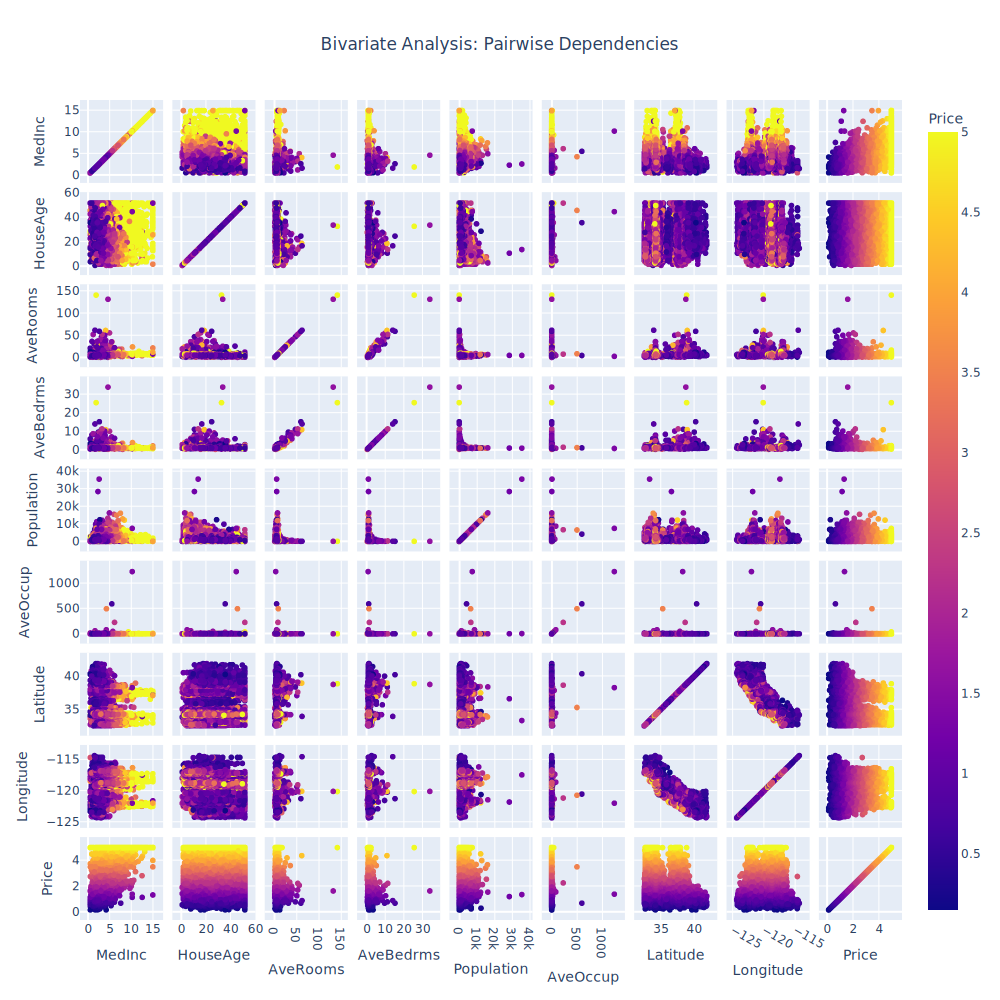

In [37]:
# Visualisation des dépendances par paire avec mise en évidence de 'Price'
fig = px.scatter_matrix(
    dataset,
    dimensions=dataset.columns,  # S'assurer que toutes les colonnes sont incluses
    color='Price',  # Colorer les points selon la variable cible 'Price'
    title="Bivariate Analysis: Pairwise Dependencies Highlighting Price"
)

# Mettre à jour les paramètres du layout
fig.update_layout(
    title=go.layout.Title(text="Bivariate Analysis: Pairwise Dependencies", x=0.5),
    autosize=True,  # Ajustement automatique de la taille en fonction de l'écran
    height=1000,  # Hauteur ajustée pour que le graphique soit moins surchargé
    width=1000,
    showlegend=False  # Supprimer la légende pour ne pas surcharger le visuel
)

# Afficher le graphique
fig.show()

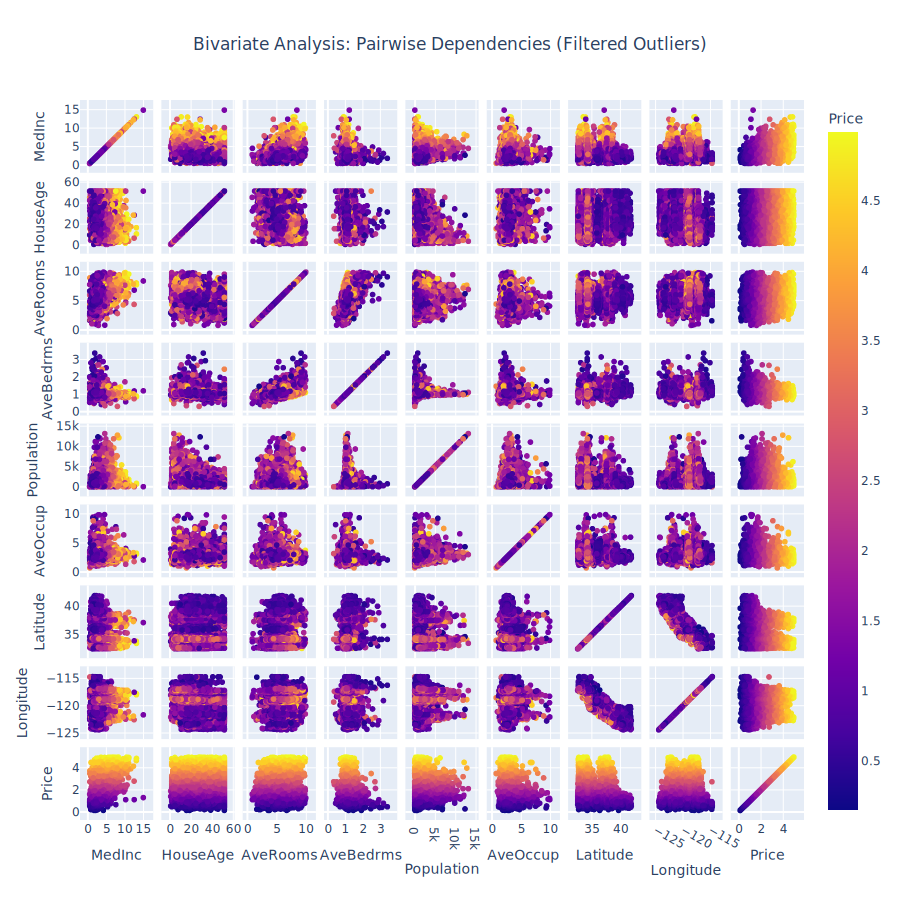

In [38]:
# Création du masque pour filtrer les outliers
mask = (
    (dataset['AveRooms'] < 10) & 
    (dataset['AveBedrms'] < 10) & 
    (dataset['Population'] < 15000) & 
    (dataset['AveOccup'] < 10) & 
    (dataset['Price'] < 5)
)

# Appliquer le masque et créer un nouveau DataFrame filtré
dataset_filtered = dataset.loc[mask].copy()

# Visualisation des dépendances par paire après suppression des outliers
fig = px.scatter_matrix(
    dataset_filtered,
    dimensions=dataset_filtered.columns,  # Inclure toutes les colonnes
    color='Price',  # Colorer par rapport à la variable cible
    title="Bivariate Analysis After Filtering Outliers"
)

# Mise à jour du layout pour ajuster la taille et supprimer la légende
fig.update_layout(
    title=go.layout.Title(text="Bivariate Analysis: Pairwise Dependencies (Filtered Outliers)", x=0.5),
    autosize=True,
    height=900,  # Taille ajustée pour un dataset plus petit
    width=900,
    showlegend=False
)

# Afficher le graphique
fig.show()

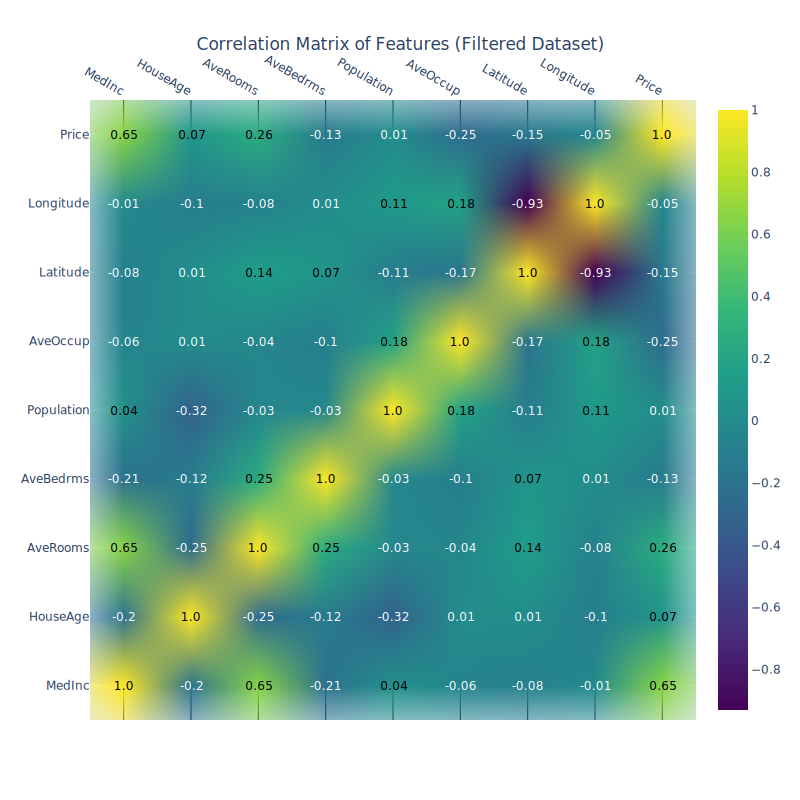

In [39]:
# Calcul de la matrice de corrélation pour le dataset filtré
corr_matrix = dataset_filtered.corr().round(2)

# Importer Plotly pour créer la heatmap annotée
import plotly.figure_factory as ff

# Création de la heatmap annotée avec des couleurs personnalisées
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,  # Valeurs de la matrice
    x=corr_matrix.columns.tolist(),  # Noms des colonnes (features)
    y=corr_matrix.index.tolist(),  # Noms des lignes (features)
    annotation_text=corr_matrix.values,  # Texte annoté avec les valeurs
    colorscale='Viridis',  # Utilisation d'une échelle de couleurs moderne
    showscale=True  # Afficher la barre des couleurs sur le côté
)

# Mise à jour du layout pour ajouter un titre et centrer le graphique
fig.update_layout(
    title=go.layout.Title(text="Correlation Matrix of Features (Filtered Dataset)", x=0.5),
    height=800,  # Hauteur ajustée pour une meilleure lisibilité
    width=800
)

# Afficher la heatmap
fig.show()

# Baseline model

In [40]:
# Séparation de la variable cible Y et des features X
print("Separating labels from features...")

# Définir les variables d'entrée et la cible
features_list = ["MedInc"]  # Nous n'utilisons que 'MedInc' pour le modèle de base
target_variable = "Price"  # La cible est 'Price'

# Extraire les features (X) et la cible (Y) du dataset filtré
X = dataset_filtered.loc[:, features_list]
Y = dataset_filtered.loc[:, target_variable]

print("...Done.")
print()

# Afficher un aperçu des premières lignes de Y (cible)
print('Y (Target - Price) :')
print(Y.head())
print()

# Afficher un aperçu des premières lignes de X (feature - MedInc)
print('X (Feature - MedInc) :')
print(X.head())

Separating labels from features...
...Done.

Y (Target - Price) :
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Price, dtype: float64

X (Feature - MedInc) :
   MedInc
0  8.3252
1  8.3014
2  7.2574
3  5.6431
4  3.8462


In [41]:
# Séparation du jeu de données en train/test (80% entraînement, 20% test)
# random_state=42 est utilisé pour assurer la reproductibilité de la division
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Affichage des dimensions des datasets pour validation
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (15518, 1)
X_test shape: (3880, 1)
Y_train shape: (15518,)
Y_test shape: (3880,)


In [42]:
# Affichage du nombre de lignes dans le dataset
print(f"Number of rows: {dataset_filtered.shape[0]}\n")

# Affichage des premières lignes du dataset filtré
print("Display of dataset (first 5 rows):")
display(dataset_filtered.head())
print()

# Statistiques descriptives de base pour le dataset
print("Basic statistics: ")
data_desc = dataset_filtered.describe(include='all')
display(data_desc)
print()

# Calcul et affichage du pourcentage de valeurs manquantes par colonne
print("Percentage of missing values per column: ")
missing_values = (100 * dataset_filtered.isnull().sum() / dataset_filtered.shape[0]).round(2)
display(missing_values)

Number of rows: 19398

Display of dataset (first 5 rows):


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Basic statistics: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000,19398.000000
mean,3.674497,28.496907,5.210648,1.066038,1442.172080,2.944640,35.637872,-119.567484,1.924128
std,1.563397,12.477953,1.168098,0.128846,1077.498768,0.766194,2.142960,2.004793,0.971784
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.525900,18.000000,4.407329,1.005413,805.000000,2.450413,33.930000,-121.770000,1.167000
50%,3.447800,29.000000,5.170038,1.047619,1185.500000,2.842105,34.260000,-118.490000,1.741000
75%,4.583175,37.000000,5.944617,1.096884,1752.000000,3.308127,37.720000,-118.000000,2.485000
max,15.000100,52.000000,9.979167,3.411111,13251.000000,9.954545,41.950000,-114.550000,4.991000



Percentage of missing values per column: 


MedInc        0.0
HouseAge      0.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
Price         0.0
dtype: float64

We have only numeric features with no missing values, so here the preprocessing is very simple: we just want to standardize all the columns!

In [43]:
# Standardisation des features
print("Preprocessing X_train...")

# Afficher les premières lignes avant la standardisation
print("X_train before scaling:")
print(X_train.head())
print()

# Initialiser le scaler
scaler = StandardScaler()

# Appliquer la standardisation sur X_train
X_train_scaled = scaler.fit_transform(X_train)

# Afficher les premières lignes après la standardisation
print("...Done!")
print("X_train after scaling (first 5 rows):")
print(X_train_scaled[:5, :])  # Afficher les 5 premières lignes

# Vérifier que X_train est bien transformé en un tableau numpy
print(f"\nX_train is now a numpy array: {type(X_train_scaled)}")

Preprocessing X_train...
X_train before scaling:
       MedInc
15015  2.9624
2823   5.5261
2795   2.3250
1360   3.3661
12795  1.5600

...Done!
X_train after scaling (first 5 rows):
[[-0.45883376]
 [ 1.1903096 ]
 [-0.86885209]
 [-0.19914692]
 [-1.36095127]]

X_train is now a numpy array: <class 'numpy.ndarray'>


In [44]:
# Standardisation des features pour X_test (sans réajuster le scaler)
print("Preprocessing X_test...")

# Afficher les premières lignes avant la standardisation
print("X_test before scaling:")
print(X_test.head())
print()

# Appliquer la transformation déjà ajustée sur X_test
X_test_scaled = scaler.transform(X_test)  # Ne pas refitter le scaler

# Afficher les premières lignes après la standardisation
print("...Done!")
print("X_test after scaling (first 5 rows):")
print(X_test_scaled[:5, :])

# Vérifier que X_test est bien transformé en un tableau numpy
print(f"\nX_test is now a numpy array: {type(X_test_scaled)}")

Preprocessing X_test...
X_test before scaling:
       MedInc
13065  4.5766
2516   3.0469
12039  3.3187
17668  3.2806
2426   2.2206

...Done!
X_test after scaling (first 5 rows):
[[ 0.57952767]
 [-0.40447771]
 [-0.22963777]
 [-0.25414624]
 [-0.93600915]]

X_test is now a numpy array: <class 'numpy.ndarray'>


In [45]:
# Entraînement du modèle de régression linéaire
print("Training the baseline model with 'MedInc' as the feature...")
regressor = LinearRegression()

# Entraîner sur les données d'entraînement
regressor.fit(X_train_scaled, Y_train)
print("...Training done.")

Training the baseline model with 'MedInc' as the feature...
...Training done.


In [46]:
# Calculer et afficher le score R² directement avec regressor.score()
print(f"R2 score on training set: {regressor.score(X_train_scaled, Y_train):.4f}")
print(f"R2 score on test set: {regressor.score(X_test_scaled, Y_test):.4f}")

R2 score on training set: 0.4167
R2 score on test set: 0.4344


In [47]:
# Prédictions sur l'ensemble d'entraînement
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train_scaled)
print("...Done.")

# Affichage des premières prédictions
print("First 5 predictions on training set:")
print(Y_train_pred[:5])
print()

Predictions on training set...
...Done.
First 5 predictions on training set:
[1.63713472 2.66860053 1.3806865  1.7995573  1.07290036]



In [48]:
# Prédictions sur l'ensemble de test
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test_scaled)
print("...Done.")

# Affichage des premières prédictions
print("First 5 predictions on test set:")
print(Y_test_pred[:5])
print()

Predictions on test set...
...Done.
First 5 predictions on test set:
[2.28658361 1.67113202 1.78048663 1.76515767 1.33868275]



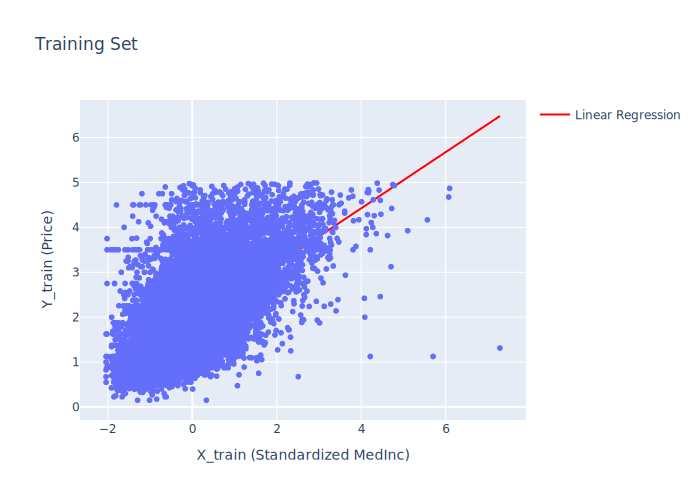

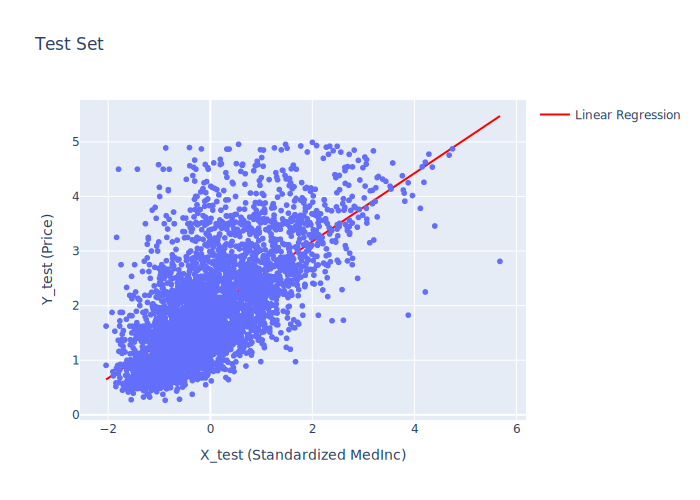

In [49]:
# Visualiser les prédictions sur l'ensemble d'entraînement
fig = px.scatter(x=X_train_scaled.flatten(), y=Y_train, title="Training Set")
fig.add_trace(go.Scatter(x=X_train_scaled.flatten(), y=Y_train_pred, name="Linear Regression", line=dict(color='red')))
fig.update_layout(
    xaxis_title="X_train (Standardized MedInc)",
    yaxis_title="Y_train (Price)"
)
fig.show()

# Visualiser les prédictions sur l'ensemble de test
fig = px.scatter(x=X_test_scaled.flatten(), y=Y_test, title="Test Set")
fig.add_trace(go.Scatter(x=X_test_scaled.flatten(), y=Y_test_pred, name="Linear Regression", line=dict(color='red')))
fig.update_layout(
    xaxis_title="X_test (Standardized MedInc)",
    yaxis_title="Y_test (Price)"
)
fig.show()

# Multivariate model

In [50]:
# Séparation de la variable cible Y et des features X
print("Separating labels from features...")

# La variable cible
target_variable = "Price"

# Sélection de toutes les features sauf 'Price'
X = dataset_filtered.drop(target_variable, axis=1)  # On supprime la colonne 'Price' pour obtenir X
Y = dataset_filtered[target_variable]  # On garde uniquement la colonne 'Price' comme variable cible

print("...Done.")
print()

# Affichage des premières lignes de Y (variable cible)
print('Y (Target - Price) :')
print(Y.head())
print()

# Affichage des premières lignes de X (features)
print('X (Features) :')
print(X.head())

Separating labels from features...
...Done.

Y (Target - Price) :
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Price, dtype: float64

X (Features) :
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


In [51]:
# Division du dataset en ensembles d'entraînement et de test
print("Dividing dataset into train and test sets...")

# Division avec 80% pour l'entraînement et 20% pour le test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("...Done.")
print()

# Affichage des dimensions des ensembles d'entraînement et de test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

Dividing dataset into train and test sets...
...Done.

X_train shape: (15518, 8)
X_test shape: (3880, 8)
Y_train shape: (15518,)
Y_test shape: (3880,)


In [52]:
# Prétraitement : standardisation des features de X_train
print("Preprocessing X_train...")
print("First 5 rows of X_train before scaling:")
print(X_train.head())  # Afficher les premières lignes avant la standardisation
print()

# Initialiser le scaler et ajuster/transformer X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Transformer et standardiser les données

print("...Done!")
print("First 5 rows of X_train after scaling:")
print(X_train_scaled[:5, :])  # Afficher les 5 premières lignes après transformation (maintenant tableau numpy)

Preprocessing X_train...
First 5 rows of X_train before scaling:
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
3235   2.3889       6.0  6.316614   1.294671       992.0  3.109718     36.09   
13981  3.4912       7.0  8.355308   1.554795      2933.0  2.511130     34.85   
9219   1.9464      36.0  4.975510   1.053061       639.0  2.608163     37.12   
10851  3.1667      22.0  3.803838   1.000000      1952.0  2.081023     33.66   
8888   4.2520      31.0  3.978296   1.039389      1985.0  1.595659     34.03   

       Longitude  
3235     -119.57  
13981    -117.46  
9219     -120.27  
10851    -117.90  
8888     -118.49  

...Done!
First 5 rows of X_train after scaling:
[[-8.19927084e-01 -1.80892400e+00  9.55328430e-01  1.78190047e+00
  -4.16134941e-01  2.18006083e-01  2.11764744e-01 -2.73283112e-03]
 [-1.12594285e-01 -1.72879039e+00  2.70646520e+00  3.80387675e+00
   1.40114366e+00 -5.61637519e-01 -3.67622089e-01  1.05246805e+00]
 [-1.10387407e+00  5.9508

In [53]:
# Prétraitement : standardisation des features de X_test (ne pas refitter le scaler)
print("Preprocessing X_test...")
print("First 5 rows of X_test before scaling:")
print(X_test.head())  # Afficher les premières lignes avant la standardisation
print()

# Appliquer la transformation déjà ajustée sur X_test
X_test_scaled = scaler.transform(X_test)  # Ne pas refitter, utiliser le scaler ajusté avec X_train

print("...Done!")
print("First 5 rows of X_test after scaling:")
print(X_test_scaled[:5, :])  # Afficher les 5 premières lignes après transformation (maintenant tableau numpy)

Preprocessing X_test...
First 5 rows of X_test before scaling:
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
17333  5.2990      12.0  7.214932   1.047511      1200.0  2.714932     34.91   
1012   2.6667      44.0  4.541284   1.027523       277.0  2.541284     37.68   
5124   1.5521      30.0  3.850679   1.002262      1966.0  4.447964     33.99   
1845   6.3538      49.0  6.293886   1.017751      1148.0  2.264300     37.90   
4035   3.2154      20.0  4.133444   1.060181      7450.0  1.772122     34.17   

       Longitude  
17333    -120.44  
1012     -121.77  
5124     -118.26  
1845     -122.28  
4035     -118.52  

...Done!
First 5 rows of X_test after scaling:
[[ 1.04744947 -1.32812236  1.72693875 -0.13930381 -0.22139308 -0.29619119
  -0.33958724 -0.43781566]
 [-0.64166613  1.23615306 -0.56959193 -0.29467615 -1.08556008 -0.52236244
   0.95468818 -1.10294228]
 [-1.35689169  0.11428257 -1.16278792 -0.49102935  0.49578127  1.96103359
  -0.76945489  0.6

In [54]:
# Entraînement du modèle de régression linéaire
print("Training the multivariate model with all features...")
regressor = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
regressor.fit(X_train_scaled, Y_train)
print("...Done.")

Training the multivariate model with all features...
...Done.


In [55]:
# Calcul et affichage des scores R²
print("R2 score on training set: ", regressor.score(X_train_scaled, Y_train))
print("R2 score on test set: ", regressor.score(X_test_scaled, Y_test))

R2 score on training set:  0.6270641950558857
R2 score on test set:  0.6357478886974353


# utilisation que de 3 variables: AveRooms, AveOccup, et Latitude

In [56]:
### Sélectionner uniquement les variables AveRooms, AveOccup, et Latitude
### features_list = ["AveRooms", "AveOccup", "Latitude"]
### X = dataset_filtered[features_list]

### Diviser le dataset en train et test sets
### X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Standardisation des features
### scaler = StandardScaler()
### X_train_scaled = scaler.fit_transform(X_train)
### X_test_scaled = scaler.transform(X_test)

### Entraîner le modèle
### print("Training the model with selected features (AveRooms, AveOccup, Latitude)...")
### regressor = LinearRegression()
### regressor.fit(X_train_scaled, Y_train)
### print("...Done.")

### Afficher les scores R²
### print("R2 score on training set: ", regressor.score(X_train_scaled, Y_train))
### print("R2 score on test set: ", regressor.score(X_test_scaled, Y_test))

Bon il vaut mieux prendre le tout donc;) le résultat était vriament mauvais. je désactive le code pour que la feature importante ci dessus puisse bien prendre en considération l'ensemble des features et pas que les 3 colonnes

# Feature importance

In [57]:
# Liste des noms de colonnes, sauf la variable cible
column_names = [c for c in dataset_filtered.columns if c != target_variable]

# Créer un DataFrame pour afficher les coefficients
coefs = pd.DataFrame(index=column_names, data=regressor.coef_.transpose(), columns=["coefficients"])

# Afficher les coefficients
coefs.sort_values(by="coefficients", ascending=False)

,coefficients
MedInc,0.675650
HouseAge,0.117918
AveBedrms,0.112168
Population,0.043858
AveRooms,-0.138904
AveOccup,-0.209342
Longitude,-0.792648
Latitude,-0.849220


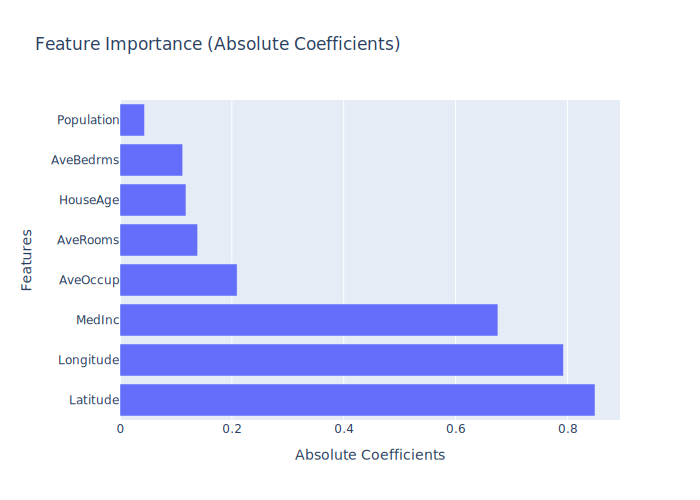

In [58]:
# Calculer l'importance des features avec abs() et trier par coefficients
feature_importance = abs(coefs).sort_values(by='coefficients', ascending=False)

# Visualiser l'importance des features avec un graphique à barres horizontales
fig = px.bar(feature_importance, orientation='h', title="Feature Importance (Absolute Coefficients)")

# Ajuster la mise en page pour éviter que les noms de colonnes soient coupés
fig.update_layout(showlegend=False, 
                  margin={'l': 120},  # Ajustement de la marge gauche pour éviter de couper les noms de colonnes
                  xaxis_title="Absolute Coefficients",
                  yaxis_title="Features")

# Afficher le graphique
fig.show()

Conclusion : the most important features are Latitude, Longitude, MedInc and AveOccup. It's interesting to notice that the model doesn't necessarily rank the features according to the values of the correlation coefficients. The reason why is that the correlation coefficient probes the linear relationship between the target and ONE feature at a time, whereas the model looks for the best COMBINATION of features.